In [22]:
#use a pretrained model(week6 ADS): https://tfhub.dev/tensorflow/tfjs-model/posenet/resnet50/quantized/1/1/default/1

# Kaggle API


In [23]:
#This cell has to be runned when you want to upload the API token file to google colab, cell below if local
#if you use a local jupyter notebook the kaggle.json has to be in the following path --> C:\Users\User\.kaggle

from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

ModuleNotFoundError: No module named 'google.colab'

In [131]:
#use this cell if you working local and if you work in google colab use the cell above
# Then move kaggle.json into the folder where the API expects to find it.
#!pip install kaggle 
#freigeben falls zum ersten Mal
import kaggle
#!mkdir -p ~\.kaggle\ && move kaggle.json \.kaggle\ && chmod 600 ~\.kaggle\kaggle.json 
# move anstelle von mv verwenden bei Windows

#wenn / gemäss Internet \ verwenden, da Syntax nicht korrekt, jedoch weiter Warnungen...

In [132]:
#search for a dataset
!kaggle datasets list -s 'rock-paper-scissor'


ref                                                             title                                          size  lastUpdated          downloadCount  voteCount  usabilityRating  
--------------------------------------------------------------  --------------------------------------------  -----  -------------------  -------------  ---------  ---------------  
datasets/frtgnn/rock-paper-scissor                              Rock - Paper - Scissor                        220MB  2019-11-07 17:52:43            470         81  0.6875           
datasets/drgfreeman/rockpaperscissors                           Rock-Paper-Scissors Images                    306MB  2019-03-01 01:01:11           8317        148  0.875            
datasets/sanikamal/rock-paper-scissors-dataset                  Rock Paper Scissors Dataset                   452MB  2019-04-24 19:53:04           2772         60  0.875            
datasets/glushko/rock-paper-scissors-dataset                    Rock, Paper, Scissors Data

In [133]:
#download a dataset
!kaggle datasets download -d drgfreeman/rockpaperscissors
!kaggle datasets download -d anirudhabhagwat/rock-paper-scissors-images 
!kaggle datasets download -d shounakdesai/rock-paper-and-scissor-images 
!kaggle datasets download -d gauravduttakiit/rock-paper-scissors-using-mobilenetv2
#Name ohne '' gemacht, damit es funktioniert hat...

rockpaperscissors.zip: Skipping, found more recently modified local copy (use --force to force download)




  0%|          | 0.00/226M [00:00<?, ?B/s]
  2%|1         | 4.00M/226M [00:00<00:06, 34.4MB/s]
  4%|3         | 8.00M/226M [00:00<00:10, 21.8MB/s]
  5%|4         | 11.0M/226M [00:00<00:15, 14.6MB/s]
  7%|6         | 15.0M/226M [00:00<00:11, 19.9MB/s]
  8%|7         | 18.0M/226M [00:01<00:19, 11.2MB/s]
 10%|9         | 22.0M/226M [00:01<00:13, 15.3MB/s]
 12%|#1        | 26.0M/226M [00:01<00:11, 19.0MB/s]
 14%|#3        | 31.0M/226M [00:01<00:08, 24.4MB/s]
 15%|#5        | 35.0M/226M [00:01<00:07, 27.5MB/s]
 18%|#7        | 40.0M/226M [00:01<00:06, 31.3MB/s]
 20%|#9        | 45.0M/226M [00:02<00:05, 34.5MB/s]
 22%|##1       | 49.0M/226M [00:02<00:05, 33.6MB/s]
 23%|##3       | 53.0M/226M [00:02<00:05, 34.8MB/s]
 26%|##5       | 58.0M/226M [00:02<00:04, 37.0MB/s]
 28%|##7       | 63.0M/226M [00:02<00:04, 38.9MB/s]
 30%|##9       | 67.0M/226M [00:02<00:04, 39.6MB/s]
 32%|###1      | 72.0M/226M [00:02<00:04, 40.1MB/s]
 34%|###4      | 77.0M/226M [00:02<00:03, 40.6MB/s]
 36%|###6      | 82.


  0%|          | 0.00/35.4M [00:00<?, ?B/s]
  3%|2         | 1.00M/35.4M [00:00<00:10, 3.58MB/s]
  6%|5         | 2.00M/35.4M [00:00<00:06, 5.55MB/s]
 11%|#1        | 4.00M/35.4M [00:00<00:03, 8.46MB/s]
 17%|#6        | 6.00M/35.4M [00:00<00:02, 10.8MB/s]
 23%|##2       | 8.00M/35.4M [00:00<00:02, 13.0MB/s]
 31%|###1      | 11.0M/35.4M [00:00<00:01, 16.8MB/s]
 40%|###9      | 14.0M/35.4M [00:01<00:01, 20.5MB/s]
 48%|####8     | 17.0M/35.4M [00:01<00:00, 22.0MB/s]
 62%|######2   | 22.0M/35.4M [00:01<00:00, 28.3MB/s]
 73%|#######3  | 26.0M/35.4M [00:01<00:00, 31.4MB/s]
 85%|########4 | 30.0M/35.4M [00:01<00:00, 33.8MB/s]
 99%|#########8| 35.0M/35.4M [00:01<00:00, 36.6MB/s]
100%|##########| 35.4M/35.4M [00:01<00:00, 22.5MB/s]



  0%|          | 0.00/14.7M [00:00<?, ?B/s]
 27%|##7       | 4.00M/14.7M [00:00<00:00, 34.5MB/s]
 54%|#####4    | 8.00M/14.7M [00:00<00:00, 26.3MB/s]
 88%|########8 | 13.0M/14.7M [00:00<00:00, 32.0MB/s]
100%|##########| 14.7M/14.7M [00:00<00:00, 32.1MB/s]


# Scraping

In [ ]:
from bs4 import BeautifulSoup
import requests

#set page url 

URL = "https://www.google.com/search?q=rock-paper-scissors+hand+sign&tbm=isch&ved=2ahUKEwiphtPg4J_3AhVN3IUKHe6hD5AQ2-cCegQIABAA&oq=rock-paper-scissors+hand+sign&gs_lcp=CgNpbWcQAzIECAAQHjIGCAAQCBAeOgcIIxDvAxAnOggIABAIEB4QEzoGCAAQBxAeOgQIABATOggIABAHEB4QEzoICAAQCBAHEB5QvgZY01VgildoEHAAeACAAfgBiAHwGJIBBjI5LjUuMpgBAKABAaoBC2d3cy13aXotaW1nwAEB&sclient=img&ei=JnleYqnbAs24lwTuw76ACQ&bih=831&biw=1680&rlz=1C5CHFA_enCH928CH928"
page = requests.get(URL)


soup = BeautifulSoup(page.content, 'html.parser')

#find all urls in img-tag <img> with class="yWs4tf"
image_tags = soup.find_all('img', class_='yWs4tf')


#add all urls to links-dict
links = []
for image_tag in image_tags:
    links.append(image_tag['src'])

#request all pictures and save

import urllib.request
for i, url in enumerate(links):
    urllib.request.urlretrieve(url, str('photo_' + str(i+1) + '.jpg'))

# Hand Classification with Transfer Learning & Fine Tuning

In [42]:
# TensorFlow and tf.keras
#!pip install tensorflow
#! pip install tensorflow_datasets
import tensorflow as tf
import os

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt
import PIL
import PIL.Image
import tensorflow_datasets as tfds

print(tf.__version__)
print(tf.config.list_physical_devices())

2.8.0
[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]


In [43]:
#setup folder where you will save logs for tensorflow 
root_logdir = os.path.join(os.curdir,"my_logs_project")


def get_run_logdir():
    import time
    run_id = time.strftime("run_%Y_%m_%d-%H_%M_%S")
    return os.path.join(root_logdir, run_id)

run_logdir = get_run_logdir()

In [142]:
from zipfile import ZipFile

# Create a ZipFile Object and load file.zip in it
with ZipFile('rockpaperscissors.zip', 'r') as zipObj:
    # Extract all the contents of zip file in current directory
   zipObj.extractall('rockpaperscissors')



In [98]:
import shutil
import os
   
# location
location = 'rockpaperscissors'
   
# director
dir = 'rps-cv-images'
   
# path
path = os.path.join(location, dir)   
# removing directory
shutil.rmtree(path)


In [99]:
data_dir = os.path.join(os.curdir, 'rockpaperscissors')
                        
BATCH_SIZE = 32
IMG_SIZE = (192,192)

train_dataset = tf.keras.utils.image_dataset_from_directory(data_dir,
                                                            batch_size=BATCH_SIZE,
                                                            image_size=IMG_SIZE,
                                                            shuffle=True,
                                                            seed=999,
                                                            validation_split=0.20,
                                                            subset = "training")

validation_dataset = tf.keras.utils.image_dataset_from_directory(data_dir,
                                                            batch_size=BATCH_SIZE,
                                                            image_size=IMG_SIZE,
                                                            shuffle=True,
                                                            seed=999,
                                                            validation_split=0.20,
                                                            subset = "validation")


Found 2188 files belonging to 3 classes.
Using 1751 files for training.
Found 2188 files belonging to 3 classes.
Using 437 files for validation.


In [100]:
class_names = train_dataset.class_names
print(class_names)

['paper', 'rock', 'scissors']


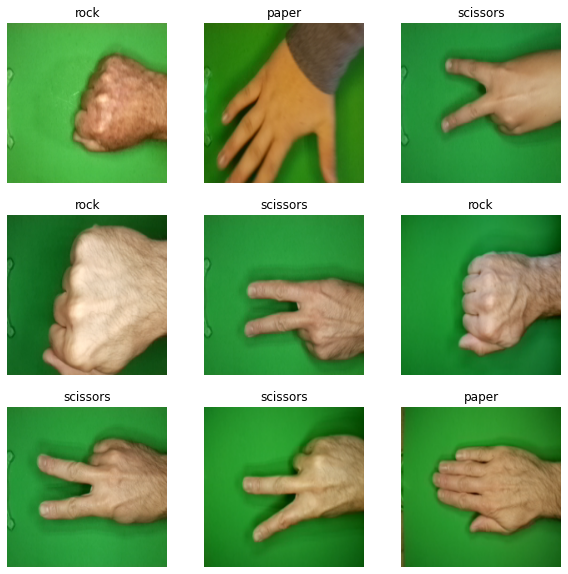

In [101]:
plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [102]:
val_batches = tf.data.experimental.cardinality(validation_dataset)
test_dataset = validation_dataset.take(val_batches // 5)
val_dataset = validation_dataset.skip(val_batches // 5)

In [103]:

print('Number of validation batches: %d' % tf.data.experimental.cardinality(validation_dataset))
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_dataset))

Number of validation batches: 14
Number of test batches: 2


In [104]:
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

## Data augementation

In [105]:
with tf.device('/cpu:0'):
    data_augmentation = tf.keras.Sequential([
      tf.keras.layers.RandomRotation(0.3, fill_mode='reflect', interpolation='bilinear', seed=None, fill_value=0.0) 
    ])

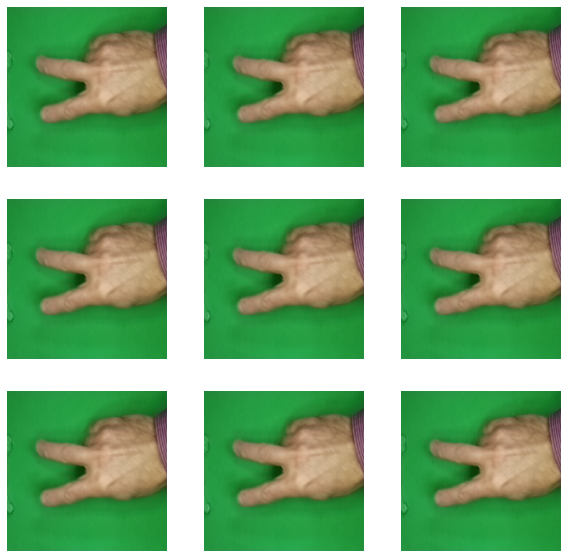

In [106]:
with tf.device('/cpu:0'):
    for image, _ in train_dataset.take(1):
      plt.figure(figsize=(10, 10))
      first_image = image[0]
      for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
        plt.imshow(augmented_image[0] / 255)
        plt.axis('off')

### Choose Transfer Learning Model

In [107]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

In [108]:
# Create the base model from the pre-trained model MobileNet V2

IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

In [109]:
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 6, 6, 1280)


In [110]:
base_model.trainable = False

In [111]:
base_model.summary()

Model: "mobilenetv2_1.00_192"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_7 (InputLayer)           [(None, 192, 192, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 96, 96, 32)   864         ['input_7[0][0]']                
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 96, 96, 32)   128         ['Conv1[0][0]']                  
                                                                                                  
 Conv1_relu (ReLU)              (None, 96, 96, 32)   0           ['bn_Conv1[0][

 nv2D)                                                                                            
                                                                                                  
 block_3_depthwise_BN (BatchNor  (None, 24, 24, 144)  576        ['block_3_depthwise[0][0]']      
 malization)                                                                                      
                                                                                                  
 block_3_depthwise_relu (ReLU)  (None, 24, 24, 144)  0           ['block_3_depthwise_BN[0][0]']   
                                                                                                  
 block_3_project (Conv2D)       (None, 24, 24, 32)   4608        ['block_3_depthwise_relu[0][0]'] 
                                                                                                  
 block_3_project_BN (BatchNorma  (None, 24, 24, 32)  128         ['block_3_project[0][0]']        
 lization)

 ization)                                                                                         
                                                                                                  
 block_7_expand_relu (ReLU)     (None, 12, 12, 384)  0           ['block_7_expand_BN[0][0]']      
                                                                                                  
 block_7_depthwise (DepthwiseCo  (None, 12, 12, 384)  3456       ['block_7_expand_relu[0][0]']    
 nv2D)                                                                                            
                                                                                                  
 block_7_depthwise_BN (BatchNor  (None, 12, 12, 384)  1536       ['block_7_depthwise[0][0]']      
 malization)                                                                                      
                                                                                                  
 block_7_d

 block_10_project_BN (BatchNorm  (None, 12, 12, 96)  384         ['block_10_project[0][0]']       
 alization)                                                                                       
                                                                                                  
 block_11_expand (Conv2D)       (None, 12, 12, 576)  55296       ['block_10_project_BN[0][0]']    
                                                                                                  
 block_11_expand_BN (BatchNorma  (None, 12, 12, 576)  2304       ['block_11_expand[0][0]']        
 lization)                                                                                        
                                                                                                  
 block_11_expand_relu (ReLU)    (None, 12, 12, 576)  0           ['block_11_expand_BN[0][0]']     
                                                                                                  
 block_11_

                                                                                                  
 block_14_depthwise_relu (ReLU)  (None, 6, 6, 960)   0           ['block_14_depthwise_BN[0][0]']  
                                                                                                  
 block_14_project (Conv2D)      (None, 6, 6, 160)    153600      ['block_14_depthwise_relu[0][0]']
                                                                                                  
 block_14_project_BN (BatchNorm  (None, 6, 6, 160)   640         ['block_14_project[0][0]']       
 alization)                                                                                       
                                                                                                  
 block_14_add (Add)             (None, 6, 6, 160)    0           ['block_13_project_BN[0][0]',    
                                                                  'block_14_project_BN[0][0]']    
          

In [112]:
inputs = tf.keras.Input(shape=IMG_SHAPE)
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False) #We need to set `training=False` as our model contains a `BatchNormalization` layer. More explanation here https://www.tensorflow.org/guide/keras/transfer_learning
x = tf.keras.layers.GlobalAveragePooling2D()(x) #this layer has the same purpose as tf.keras.layers.Flatten(). Need to connect something 2D to something 1D. Ask if you want to know more :)
x = tf.keras.layers.Dense(64, activation="relu")(x)
x = tf.keras.layers.Dropout(rate=0.2)(x)
x = tf.keras.layers.Dense(32, activation="relu")(x)
x = tf.keras.layers.Dropout(rate=0.2)(x)
x = tf.keras.layers.Dense(16, activation="relu")(x)
x = tf.keras.layers.Dropout(rate=0.2)(x)
outputs = tf.keras.layers.Dense(1, activation="softmax")(x) 
model = tf.keras.Model(inputs, outputs)

#### Compile the mode

In [113]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
              metrics=['accuracy'])

In [114]:
model.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 192, 192, 3)]     0         
                                                                 
 sequential_3 (Sequential)   (None, 192, 192, 3)       0         
                                                                 
 tf.math.truediv_3 (TFOpLamb  (None, 192, 192, 3)      0         
 da)                                                             
                                                                 
 tf.math.subtract_3 (TFOpLam  (None, 192, 192, 3)      0         
 bda)                                                            
                                                                 
 mobilenetv2_1.00_192 (Funct  (None, 6, 6, 1280)       2257984   
 ional)                                                          
                                                           

### Train the model

In [115]:
initial_epochs = 5

loss0, accuracy0 = model.evaluate(validation_dataset)

14/14 [==============================] - 12s 633ms/step - loss: 0.7831 - accuracy: 0.3638


In [116]:
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

initial loss: 0.78
initial accuracy: 0.36


In [117]:
early_stopping_cb=tf.keras.callbacks.EarlyStopping(patience=4, restore_best_weights=True)
history = model.fit(train_dataset,
                    epochs=initial_epochs,
                    validation_data=validation_dataset)

Epoch 1/5
55/55 [==============================] - 58s 967ms/step - loss: 0.3983 - accuracy: 0.3238 - val_loss: 0.0326 - val_accuracy: 0.3638
Epoch 2/5
55/55 [==============================] - 54s 972ms/step - loss: 0.0150 - accuracy: 0.3238 - val_loss: -0.3252 - val_accuracy: 0.3638
Epoch 3/5
55/55 [==============================] - 56s 1s/step - loss: -0.6916 - accuracy: 0.3238 - val_loss: -1.0962 - val_accuracy: 0.3638
Epoch 4/5
55/55 [==============================] - 56s 1s/step - loss: -1.7948 - accuracy: 0.3238 - val_loss: -2.4142 - val_accuracy: 0.3638
Epoch 5/5
55/55 [==============================] - 54s 970ms/step - loss: -3.5540 - accuracy: 0.3238 - val_loss: -4.5176 - val_accuracy: 0.3638


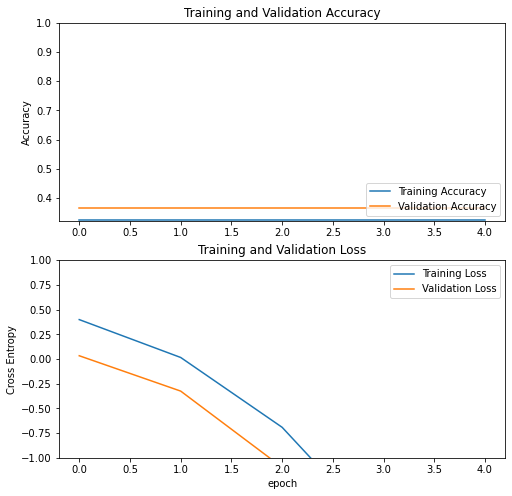

In [118]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([-1.0,1])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

## Fine tuning

In [119]:
base_model.trainable = True

In [120]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable = False

Number of layers in the base model:  154


In [121]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
              optimizer = tf.keras.optimizers.RMSprop(learning_rate=base_learning_rate/10),
              metrics=['accuracy'])

In [122]:
model.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 192, 192, 3)]     0         
                                                                 
 sequential_3 (Sequential)   (None, 192, 192, 3)       0         
                                                                 
 tf.math.truediv_3 (TFOpLamb  (None, 192, 192, 3)      0         
 da)                                                             
                                                                 
 tf.math.subtract_3 (TFOpLam  (None, 192, 192, 3)      0         
 bda)                                                            
                                                                 
 mobilenetv2_1.00_192 (Funct  (None, 6, 6, 1280)       2257984   
 ional)                                                          
                                                           

In [123]:
fine_tune_epochs = 5
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model.fit(train_dataset,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=validation_dataset)

Epoch 5/10
55/55 [==============================] - 81s 1s/step - loss: -22.0666 - accuracy: 0.3238 - val_loss: -32.8508 - val_accuracy: 0.3638
Epoch 6/10
55/55 [==============================] - 73s 1s/step - loss: -52.7703 - accuracy: 0.3238 - val_loss: -58.1263 - val_accuracy: 0.3638
Epoch 7/10
55/55 [==============================] - 74s 1s/step - loss: -76.9238 - accuracy: 0.3238 - val_loss: -76.9117 - val_accuracy: 0.3638
Epoch 8/10
55/55 [==============================] - 76s 1s/step - loss: -93.6542 - accuracy: 0.3238 - val_loss: -90.5942 - val_accuracy: 0.3638
Epoch 9/10
55/55 [==============================] - 77s 1s/step - loss: -104.2251 - accuracy: 0.3238 - val_loss: -101.6058 - val_accuracy: 0.3638
Epoch 10/10
55/55 [==============================] - 76s 1s/step - loss: -116.8893 - accuracy: 0.3238 - val_loss: -109.3513 - val_accuracy: 0.3638


In [124]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

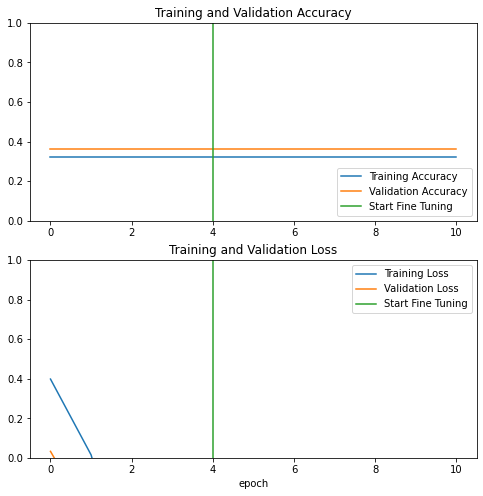

In [125]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

### Evaluation and prediction

In [126]:
loss, accuracy = model.evaluate(test_dataset)
print('Test accuracy :', accuracy)

2/2 [==============================] - 2s 754ms/step - loss: -79.9820 - accuracy: 0.5156
Test accuracy : 0.515625


Predictions:
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Labels:
 [1 0 1 2 2 2 1 0 1 0 0 1 0 0 2 0 2 2 1 0 2 1 2 2 1 1 0 0 0 1 0 0]


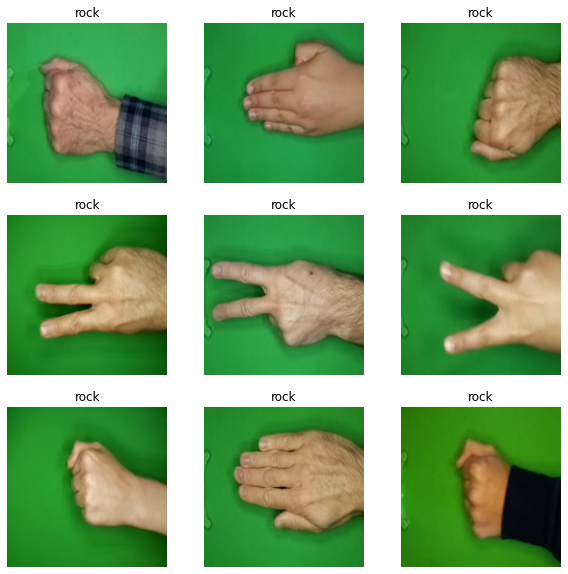

In [127]:
# Retrieve a batch of images from the test set
image_batch, label_batch = test_dataset.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch).flatten()

predictions = tf.where(predictions < 0.5, 0, 1)

print('Predictions:\n', predictions.numpy())
print('Labels:\n', label_batch)

plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i].astype("uint8"))
  plt.title(class_names[predictions[i]])
  plt.axis("off")

In [128]:
model.save("rockpaperscissors.h5")

# Use Webcam (works only local)

In [129]:
#take a picture with the integrated default camera
#pip install opencv-python
import cv2
import pymsgbox as pymsg

#access standard camera 0
videoCaptureObject = cv2.VideoCapture(0)

#show message 
msg = pymsg.alert("A picture was captured with the webcam.", 'Camera')
# OK whatever you type, it will return OK
print(msg)


#loop --> read frame and save it (set value to False)
result = True
contador = 0 
while(result):
    ret,frame = videoCaptureObject.read()
    cv2.imshow("Captura", frame)
    key = cv2.waitKey(1)
    if contador==50:
        cv2.imwrite("NewCamPicture.jpg",frame)
        result = False
    contador=contador+1

# release camera and destroy all windows
videoCaptureObject.release()
cv2.destroyAllWindows()

OK


This image most likely belongs to rock.


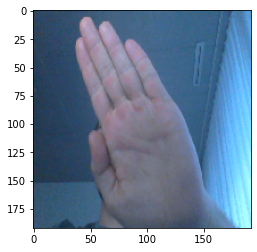

In [130]:
img = tf.keras.utils.load_img("NewCamPicture.jpg", target_size=(192,192)# your own image
)

img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Add the image to a batch where it's the only member.


prediction = model.predict_on_batch(img_array).flatten()

prediction = tf.where(prediction < 0.5, 0, 1)


print(
    "This image most likely belongs to {}."
    .format(class_names[prediction[0]])
)

plt.imshow(img)